In [43]:
from dotenv import load_dotenv

load_dotenv()

True

In [44]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [45]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
  max_results=3,
  search_depth="advanced",
  include_answer=True,
  include_raw_content=True,
  include_images=True
)

def web_search(state: AgentState):
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    return {'context': results}

In [46]:
from langchain_openai import ChatOpenAI
from langsmith import Client
from langchain_core.output_parsers import StrOutputParser

client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)
def web_generate(state: AgentState):
  context = state['context']
  query = state['query']
  rag_chain = generate_prompt | generate_llm | StrOutputParser()
  response = rag_chain.invoke({'question': query, 'context': context})
  return {'answer' : response}

In [47]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

basic_llm = ChatOpenAI(model='gpt-4o-mini')

def basic_generate(state: AgentState):
    query = state["query"]
    basic_llm_chain = basic_llm | StrOutputParser()
    llm_response = basic_llm_chain.invoke(query)
    return {'answer': llm_response}

In [48]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(
       description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'
'vector_store' contains information about income tax up to December 2024.
if you think the question is simple enough use 'llm'
if you think you need to search the web to answer the question use 'web_search'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", '{query}'),
])

router_llm = ChatOpenAI(model='gpt-4o', temperature=0)
structured_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState):
  query = state['query']
  router_chain = router_prompt | structured_router_llm
  route = router_chain.invoke({'query': query})
  print(f"Routing to: {route}")
  return route.target

In [49]:
from income_tax_graph import graph as income_tax_subgraph

graph_builder.add_node('income_tax_agent', income_tax_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

In [50]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
  START,
  router,
  {
    'vector_store': 'income_tax_agent',
    'llm': 'basic_generate',
    'web_search': 'web_search',
  } 
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [51]:
graph = graph_builder.compile()

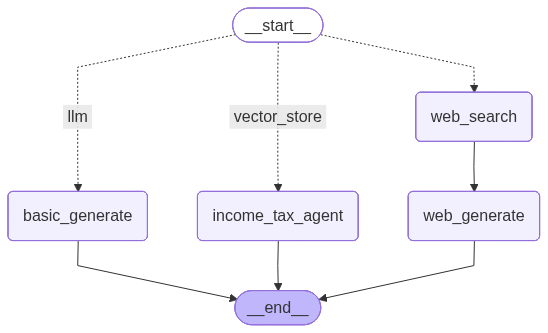

In [52]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [53]:
initial_state = {'query' : '역삼역 맛집 추천해줘'}
graph.invoke(initial_state)

Routing to: target='web_search'


{'query': '역삼역 맛집 추천해줘',
 'context': [{'title': '역삼역 맛집 리스트 2년차 직장인 또간집 TOP 30 - 네이버 블로그',
   'url': 'https://m.blog.naver.com/je3355je/223613149295',
   'content': '|  |  |  |  |  |  |\n ---  ---  --- |\n|  |  |  | 자주 먹은 메뉴 |  | 거리 |\n| 1 | 한식 | 뚝배기양평해장국 역삼직영점 | 뼈해장국 | 서울 강남구 테헤란로27길 36 1층 뚝배기양평해장국 | 역삼역 8번 출구에서 372m |\n| 2 | 일식 | 스노우폭스 역삼 GFC점 | 필라델피아롤, 와규스테이크스시 | 서울 강남구 테헤란로 152 강남파이낸스센터 지하2층 | 역삼역 2번 출구에서 27m |\n| 3 | 중식 | 명정루 | 간짜장, 짬뽕 | 서울 강남구 논현로 94길 19 1층 | 역삼역 7번 출구에서 270m |\n| 4 | 한식 | 본죽&비빔밥cafe 역삼역점 | 삼계죽 | 서울 강남구 봉은사로30길 78 2층 | 역삼역 7번 출구에서 212m |\n| 5 | 한식 | 모퉁이식당 | 고등어김치찜 | 서울 강남구 테헤란로14길 33 2층 | 역삼역 3번 출구에서 510m |\n| 6 | 한식 | 오성식당 역삼 | 쌈돼지김치찌개 | 서울 강남구 테헤란로33길 13 2층 | 역삼역 8번 출구에서 335m |\n| 7 | 샐러드 | 뷰티풀샐러드&도시락 | 목살샐러드 | 서울 강남구 테헤란로33길 26 1층 | 역삼역 8번 출구에서 428m |\n| 8 | 햄버거 | 바스버거 역삼직영점 | 바스버거 | 서울 강남구 테헤란로26길 10 성보빌딩 지하1층 | 역삼역 3번 출구에서 89m |\n| 9 | 한식술집 | 카즈야 | 김치우동 | 서울 강남구 테헤란로27길 8-4 늘봄빌딩 1층 | 역삼역 8번 출구에서 206m | [...] | 10 | 분식 | 민들레떡볶이 | 우삼겹떡볶이+튀김세트 | 서울 강남구 논현로94길 1

In [54]:
initial_state = {'query' : '연봉 5천만원인 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

Routing to: target='vector_store'
hallucination check response: not hallucinated
helpfulness check response: {'Score': 1, 'Explanation': "The student's answer is concise and directly addresses the question by providing the specific amount of income tax (624만원) for a resident with an annual income of 5천만원. The explanation of how the tax is calculated (applying a 24% tax rate on the amount exceeding 1400만원) is relevant and helps to understand the answer. Therefore, the answer meets all the criteria for a score of 1."}


{'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='f11921a1-2218-442d-a550-4d8dc8ff082e', metadata={'source': './document/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 20

In [55]:
initial_state = {'query' : '대한민국의 수도는?'}
graph.invoke(initial_state)

Routing to: target='llm'


{'query': '대한민국의 수도는?', 'answer': '대한민국의 수도는 서울입니다.'}